In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy import interpolate
from scipy.special import factorial2
from scipy.interpolate import splrep, splev
from scipy.special import comb
from numpy.polynomial.hermite import hermgauss
from py_vollib.black_scholes.implied_volatility import implied_volatility
vec_find_vol_rat = np.vectorize(implied_volatility)   #imp vol estimator based on P Jäckel Let's be rational
from py_vollib.black_scholes.implied_volatility import implied_volatility as bs_iv
import numpy as np
import scipy
from scipy import interpolate
from numpy import pi, sqrt, exp
import math
from utils import gaussian_expectation


In [5]:
def sigma_squared_G(t, s, theta, lambda_x, lambda_y):
    dt = s - t  # assumes s > t
    term1 = (theta**2 / (2 * lambda_x)) * (1 - np.exp(-2 * lambda_x * dt))
    term2 = ((1 - theta)**2 / (2 * lambda_y)) * (1 - np.exp(-2 * lambda_y * dt))
    term3 = (2 * theta * (1 - theta) / (lambda_x + lambda_y)) * (1 - np.exp(-(lambda_x + lambda_y) * dt))
    return term1 + term2 + term3
def horner_vector(p, n, x):
    result = np.zeros_like(x)
    for i in range(n):
        result = result * x + p[i]
    return result

In [6]:
class two_Quintic_OU():
    def __init__(self, theta, rho, lambda_x, lambda_y, N_sims, n_steps, a_k, T, Y_storage, S0):
        self.theta = theta
        self.rho = rho
        self.a_k = a_k
        self.lambda_x = lambda_x
        self.lambda_y = lambda_y
        self.N_sims = N_sims
        self.n_steps = n_steps
        self.T = T
        self.Y_storage = Y_storage
        self.S0 = S0

    def simulate_ou(self, x1, x2):
        dt = self.T / self.n_steps
        X1 = np.zeros((self.N_sims, self.n_steps + 1))
        X2 = np.zeros((self.N_sims, self.n_steps + 1))
        exp1 = np.exp(-self.lambda_x * dt)
        exp2 = np.exp(-self.lambda_y * dt)
        var1 = np.sqrt((1 - np.exp(-2 * self.lambda_x * dt)) / (2 * self.lambda_x))
        var2 = np.sqrt((1 - np.exp(-2 * self.lambda_y * dt)) / (2 * self.lambda_y))
        X1[:, 0] = x1
        X2[:, 0] = x2

        for i in range(self.n_steps):
            X1[:, i + 1] = exp1 * X1[:, i] + var1 * self.Y_storage[:, i]
            X2[:, i + 1] = exp2 * X2[:, i] + var2 * self.Y_storage[:, i]

        self.X1 = X1
        self.X2 = X2
        return X1, X2

    def simulate_OU(self, x1=0, x2=0):
        self.simulate_ou(x1, x2)
        self.Z = self.theta * self.X1 + (1 - self.theta) * self.X2
        return self.Z

    def sigma(self, ksi_0):
        poly_vals = horner_vector(self.a_k, self.Z)
        f_Z_squared = poly_vals ** 2
        expected_fx2 = np.mean(f_Z_squared, axis=0)
        t_grid = np.linspace(0, self.T, self.n_steps + 1)
        ksi_vals = ksi_0(t_grid)
        sigma_squared = f_Z_squared * ksi_vals[None, :] / expected_fx2[None, :]
        self.sigma_t = np.sqrt(sigma_squared)
        return self.sigma_t

    def simulate_logS_batched(self):
        dt = self.T / self.n_steps
        log_S = np.zeros((self.N_sims, self.n_steps + 1))
        log_S[:, 0] = np.log(self.S0)
        for i in range(1, self.n_steps + 1):
            sigma_prev = self.sigma_t[:, i - 1]
            drift = -0.5 * (self.rho * sigma_prev) ** 2 * dt
            diffusion = self.rho * sigma_prev * np.sqrt(dt) * self.Y_storage[:, i - 1]
            log_S[:, i] = log_S[:, i - 1] + drift + diffusion
        self.log_S = log_S
        return log_S

    def run_pipeline(self, ksi_0_func, x1=0, x2=0, flag='c', r=0.0):
        self.simulate_OU(x1, x2)
        self.sigma(ksi_0_func)
        log_S = self.simulate_logS_batched()
        S_T = np.exp(log_S[:, -1])

        lm = np.linspace(-0.1, 0.5, 50)
        strike_array = self.S0 * np.exp(lm)
        call_payoffs = np.maximum(S_T[:, None] - strike_array, 0)
        call_prices = np.mean(call_payoffs, axis=0)

        imp_vols = vec_find_vol_rat(call_prices, self.S0, strike_array, self.T, flag, r)
        intrinsic_values = np.maximum(self.S0 - strike_array, 0)
        valid = call_prices > intrinsic_values + 1e-4
        return strike_array[valid], imp_vols[valid]


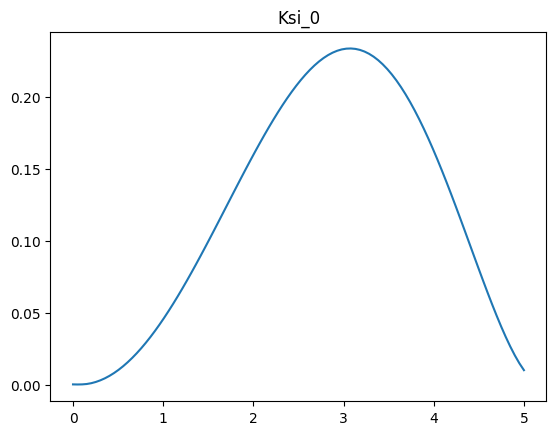

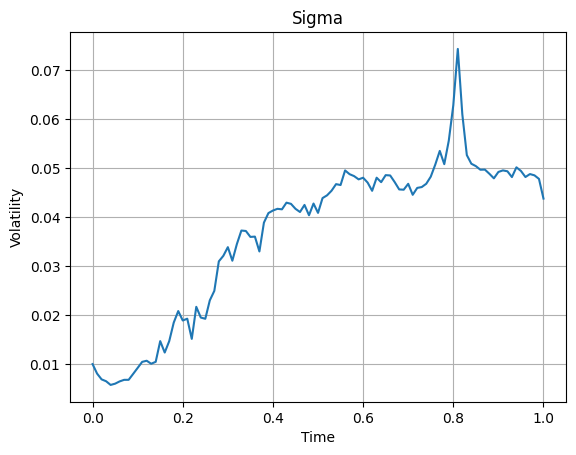

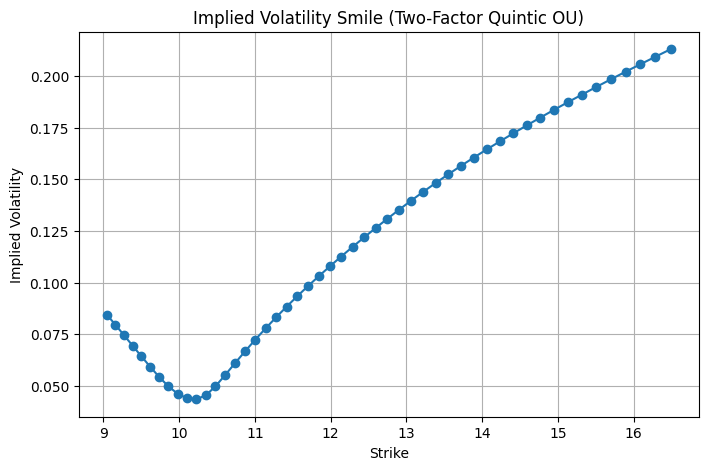

In [7]:
def horner_vector(poly, x):
    result = poly[0] * np.ones_like(x)
    for coeff in poly[1:]:
        result = result * x + coeff
    return result

def make_fv_curve_interpolator(T_array, fv_array):
    from scipy.interpolate import interp1d
    return interp1d(T_array, fv_array, kind='cubic', fill_value='extrapolate')

def vec_find_vol_rat(prices, S0, strikes, T, flag, r=0.0):
    def safe_iv(price, K):
        try:
            return implied_volatility(price, S0, K, T, r, flag)
        except Exception as e:
            print(f"IV error for price={price:.4f}, K={K:.2f}: {e}")
            return np.nan
    return np.vectorize(safe_iv)(prices, strikes)



def horner_vector(poly, x):
    result = poly[0] * np.ones_like(x)
    for coeff in poly[1:]:
        result = result * x + coeff
    return result

def vec_find_vol_rat(prices, S0, strikes, T, flag, r=0.0):
    def safe_iv(price, K):
        try:
            return implied_volatility(price, S0, K, T, r, flag)
        except Exception as e:
            print(f"IV error for price={price:.4f}, K={K:.2f}: {e}")
            return np.nan
    return np.vectorize(safe_iv)(prices, strikes)
# ==== PARAMÈTRES ====
eps = 1 / 52
H = 0.1
a_k = [0.01, 0, 0.1, 0, 0.01, 0.05]
T = 1
n_steps = 100
N_sims = 40000
lambda_x = 0.2
lambda_y = 2
S0 = 10
rho = -0.85
tetha = 0.6
# Courbe de variance à terme
T_array_nodes = np.array([0, 0.1,0.2, 0.5, 5])
fv_nodes = np.array([0.01, 0.01,0.03, 0.1, 0.1])
fv_func = make_fv_curve_interpolator(T_array_nodes, fv_nodes)
def ksi_0(t):
    return fv_func(t)**2
X0 = np.linspace(0,5,100)
Y0 = [ksi_0(x) for x in X0]
plt.plot(X0,Y0)
plt.title("Ksi_0")
plt.show()
Y_storage = np.random.randn(N_sims,n_steps)
# ==== SIMULATION ET SMILE ====
model = two_Quintic_OU(tetha, rho, lambda_x, lambda_y, N_sims, n_steps, a_k, T, Y_storage=Y_storage, S0=S0)
strikes, iv_smile = model.run_pipeline(ksi_0)

# Affichage de sigma (volatilité locale)
sigma = model.sigma_t[0, :]  # une trajectoire
X0 = np.linspace(0, T, n_steps + 1)
plt.plot(X0, sigma)
plt.title("Sigma")
plt.xlabel("Time")
plt.ylabel("Volatility")
plt.grid(True)
plt.show()

# ==== PLOT Smile ====
plt.figure(figsize=(8, 5))
plt.plot(strikes, iv_smile, marker='o')
plt.title("Implied Volatility Smile (Two-Factor Quintic OU)")
plt.xlabel("Strike")
plt.ylabel("Implied Volatility")
plt.grid(True)
plt.show()


In [8]:
def sigma_G_squared(theta, t, s, lambda_x, lambda_y):
    """
    Compute σ_G(t, s) as a function of the OU mixture parameters.

    Parameters:
    - theta: mixing weight (0 <= theta <= 1)
    - t, s: time points with s >= t
    - lambda_x, lambda_y: mean reversion speeds of the two OU processes

    Returns:
    - σ²_G(t, s): the variance function
    """
    delta = s - t

    term1 = (theta**2) / (2 * lambda_x) * (1 - np.exp(-2 * lambda_x * delta))
    term2 = ((1 - theta)**2) / (2 * lambda_y) * (1 - np.exp(-2 * lambda_y * delta))
    term3 = (2 * theta * (1 - theta)) / (lambda_x + lambda_y) * (1 - np.exp(-(lambda_x + lambda_y) * delta))

    return np.sqrt(term1 + term2 + term3)



def moment_gaussian(k, sigma):
    """
    Compute E[Z^k] for Z ~ N(0, sigma^2)

    Parameters:
    - k: integer, the order of the moment
    - sigma: standard deviation of Z

    Returns:
    - E[Z^k]
    """
    if k % 2 == 1:
        return 0.0  # odd moments are zero for symmetric Gaussian
    else:
        # Even moment: sigma^k * (k - 1)!!
        return sigma**k * math.prod(range(1, k, 2)) if k > 0 else 1.0



In [9]:
import numpy as np
import math

def moment_gaussian(k, sigma):
    """
    Compute E[Z^k] for Z ~ N(0, sigma^2)

    Parameters:
    - k: integer, the order of the moment
    - sigma: standard deviation of Z

    Returns:
    - E[Z^k]
    """
    if k % 2 == 1:
        return 0.0  # odd moments are zero for symmetric Gaussian
    else:
        # Even moment: sigma^k * (k - 1)!!
        return sigma**k * math.prod(range(1, k, 2)) if k > 0 else 1.0
    
def compute_sigma_matrix(lam_x, lam_y, t):
    def sigma_ij(lam_i, lam_j):
        return (1 - np.exp(-(lam_i + lam_j) * t)) / (lam_i + lam_j)
    
    sigma_xx = sigma_ij(lam_x, lam_x)
    sigma_yy = sigma_ij(lam_y, lam_y)
    sigma_xy = sigma_ij(lam_x, lam_y)  # same as sigma_yx

    Sigma = np.array([[sigma_xx, sigma_xy],
                      [sigma_xy, sigma_yy]])
    
    return Sigma

def h_2(x, y, beta, delta, n):
    total = 0.0
    for m in range(n):
        for l in range(m, n):
            coeff = beta[m, l]
            term = coeff * (x ** m) * (y ** (l - m))
            total += term

    if total < 0:
        raise ValueError(f"h_2 value is negative: {total:.6f}")

    return 100 * 100 * total / delta




Forward VIX: 1947.5785
VIX Options prices (first 5): [327.92141404 304.18026442 282.03977692 261.48260211 242.49299372]
Model executed successfully!
beta is  [[2.57534038e+01 4.61743260e+01 6.62306429e+01 7.79290167e+01
  8.66624640e+01 6.26308769e+01 4.27796829e+01 2.39700228e+01
  1.07446384e+01]
 [0.00000000e+00 5.13048067e+00 1.47179207e+01 2.59763389e+01
  3.85166507e+01 3.47949316e+01 2.85197886e+01 1.86433510e+01
  9.55078972e+00]
 [0.00000000e+00 0.00000000e+00 8.17662258e-01 2.88625988e+00
  6.41944178e+00 7.73220703e+00 7.92216350e+00 6.21445035e+00
  3.71419600e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.06898514e-01
  4.75514206e-01 8.59134114e-01 1.17365385e+00 1.15082414e+00
  8.25376889e-01]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  1.32087279e-02 4.77296730e-02 9.78044877e-02 1.27869349e-01
  1.14635679e-01]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 1.06065940e-03 4.34686612e-03 8.52462325e-03
  1.0189

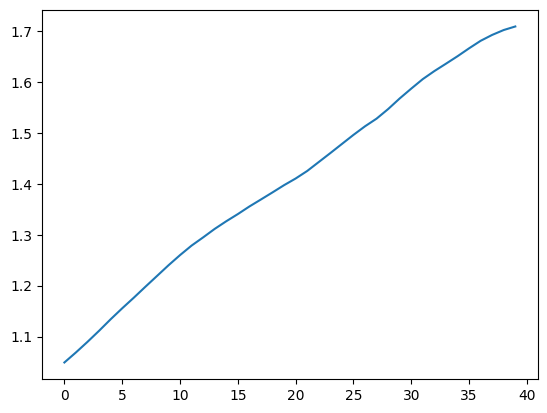

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import comb, factorial2
import scipy.special
import warnings
from py_vollib.black.implied_volatility import implied_volatility as bs_iv
from py_vollib.black_scholes.implied_volatility import implied_volatility

def vec_find_iv_rat(opt_price, S, K, t, r, flag):
    return np.vectorize(implied_volatility)(opt_price, S, K, t, r, flag)

# === Helper functions ===
def horner_vector(poly, x):
    result = poly[0] * np.ones_like(x)
    for coeff in poly[1:]:
        result = result * x + coeff
    return result

def moment_gaussian(degree, sigma):
    if degree % 2 == 0:
        return sigma ** degree * factorial2(degree - 1)
    else:
        return 0.0

def compute_sigma_matrix(lambda_x, lambda_y, T):
    var_X = (1 - np.exp(-2 * lambda_x * T)) / (2 * lambda_x)
    var_Y = (1 - np.exp(-2 * lambda_y * T)) / (2 * lambda_y)
    cov_XY = (1 - np.exp(-(lambda_x + lambda_y) * T)) / (lambda_x + lambda_y)
    return np.array([[var_X, cov_XY], [cov_XY, var_Y]])

def h_2(x, y, beta, delta, n):
    result = 0.0
    for m in range(n):
        for l in range(m, n):
            result += beta[m, l] * x ** m * y ** (l - m)
    return result / delta

# === Quantization data ===
# Note: Le chemin du fichier doit être adapté selon votre environnement
try:
    data = np.loadtxt("/home/hassene/Desktop/Stage_code/mult_dimensional_grids/1450_2_nopti")
    points = data[:-1, 1:3]
    weights = data[:-1, 0]
except FileNotFoundError:
    # Données par défaut si le fichier n'est pas trouvé
    print("Fichier de quantification non trouvé, utilisation de données par défaut")
    points = np.random.randn(100, 2)
    weights = np.ones(100) / 100

def gaussian_expectation(f, mu, Sigma, points=points, weights=weights):
    A = np.linalg.cholesky(Sigma)
    transformed_points = points @ A.T + mu
    f_vals = np.array([f(x, y) for x, y in transformed_points])
    return np.sum(f_vals * weights)

# === Main class ===
class vix_two_Quintic():
    def __init__(self, theta, rho, lambda_x, lambda_y, N_sims, n_steps, a_k, T, Y_storage, delta):
        self.theta = theta
        self.rho = rho
        self.a_k = a_k
        self.lambda_x = lambda_x
        self.lambda_y = lambda_y
        self.N_sims = N_sims
        self.n_steps = n_steps
        self.T = T
        self.delta = delta
        self.Y_storage = Y_storage
        self.beta = None
        self.Z = None
        self.X1 = None
        self.X2 = None
        self.tt_gs = None
        self.w_t_gs = None

    def simulate_ou(self, x1, x2):
        dt = (self.T + self.delta) / self.n_steps
        X1 = np.zeros((self.N_sims, self.n_steps + 1))
        X2 = np.zeros((self.N_sims, self.n_steps + 1))
        exp1 = np.exp(-self.lambda_x * dt)
        exp2 = np.exp(-self.lambda_y * dt)
        var1 = np.sqrt((1 - np.exp(-2 * self.lambda_x * dt)) / (2 * self.lambda_x))
        var2 = np.sqrt((1 - np.exp(-2 * self.lambda_y * dt)) / (2 * self.lambda_y))
        X1[:, 0] = x1
        X2[:, 0] = x2
        for i in range(self.n_steps):
            X1[:, i + 1] = exp1 * X1[:, i] + var1 * self.Y_storage[:, i]
            X2[:, i + 1] = exp2 * X2[:, i] + var2 * self.Y_storage[:, i]
        self.X1 = X1
        self.X2 = X2
        return X1, X2

    def simulate_OU(self, x1=0, x2=0):
        self.simulate_ou(x1, x2)
        self.Z = self.theta * self.X1 + (1 - self.theta) * self.X2
        return self.Z

    def sigma_G_squared(self, s_array):
        delta = self.T + self.delta - s_array
        term1 = (self.theta ** 2) / (2 * self.lambda_x) * (1 - np.exp(-2 * self.lambda_x * delta))
        term2 = ((1 - self.theta) ** 2) / (2 * self.lambda_y) * (1 - np.exp(-2 * self.lambda_y * delta))
        term3 = (2 * self.theta * (1 - self.theta)) / (self.lambda_x + self.lambda_y) * (1 - np.exp(-(self.lambda_x + self.lambda_y) * delta))
        return term1 + term2 + term3

    def co_var_func(self, theta, lambda_x, lambda_y, t, show_covar=False):
        var_1 = (1 - np.exp(-2 * lambda_x * t)) / (2 * lambda_x)
        var_2 = (1 - np.exp(-2 * lambda_y * t)) / (2 * lambda_y)
        covar = (1 - np.exp(-(lambda_x + lambda_y) * t)) / (lambda_x + lambda_y)
        var = theta**2 * var_1 + (1 - theta)**2 * var_2 + 2 * theta * (1 - theta) * covar

        if show_covar == False:
            return var
        else:
            return covar

    def compute_quadrature(self, n_t=100):
        """
        The number of quadrature points used to compute the integral in time
        """
        return np.polynomial.legendre.leggauss(n_t + 1)

    def gaussian_moments(self, sigma, degree):
        """Calcule les moments gaussiens"""
        if degree % 2 == 0:
            return sigma ** degree * factorial2(degree - 1) if degree > 0 else 1.0
        else:
            return 0.0

    def compute_cauchy_product(self, a_k):
        """Compute the Cauchy product of polynomial coefficients"""
        n = len(a_k)
        cauchy_product = np.zeros(2*n-1)
        
        for i in range(2*n-1):
            for j in range(max(0, i-n+1), min(i+1, n)):
                if i-j < n:
                    cauchy_product[i] += a_k[j] * a_k[i-j]
        
        return cauchy_product

    def compute_beta_vector_full(self, ksi_0, compute_iv=True):
        self.tt_gs, self.w_t_gs = self.compute_quadrature()
        
        T_delta = self.T + self.delta
        w_tt = self.w_t_gs / 2 * (T_delta - self.T)
        tt = 0.5 * (self.tt_gs + 1) * (T_delta - self.T) + self.T
        tt = np.linspace(self.T,self.T+self.delta,n_steps)
        w_tt = 1
        n = len(self.a_k)
        FV = ksi_0(tt)
        
        Z = self.simulate_OU()
        
        # Calcul des variances et covariances
        var_1 = (1 - np.exp(-2 * self.lambda_x * (tt - self.T))) / (2 * self.lambda_x)
        var_2 = (1 - np.exp(-2 * self.lambda_y * (tt - self.T))) / (2 * self.lambda_y)
        covar = (1 - np.exp(-(self.lambda_x + self.lambda_y) * (tt - self.T))) / (self.lambda_x + self.lambda_y)
        std_Z_t = np.sqrt(self.theta**2 * var_1 + (1 - self.theta)**2 * var_2 + 2 * self.theta * (1 - self.theta) * covar)
        
        # Calcul du produit de Cauchy
        cauchy_product = self.compute_cauchy_product(self.a_k)
        
        # Calcul de la constante de normalisation
        normal_cst = np.zeros_like(std_Z_t)
        for i in range(0, 2*n, 2):
            moment = std_Z_t**i * (factorial2(i - 1) if i > 0 else 1.0)
            normal_cst += cauchy_product[i] * moment
        
        g_0_s_squared = FV / normal_cst

        std_G_s_t = np.sqrt(self.co_var_func(self.theta, self.lambda_x, self.lambda_y, tt - self.T))
        beta_m_l = np.zeros((2*n-1, 2*n-1))
        combinatory_matrix = comb(np.arange(2*n-1)[:, np.newaxis], np.arange(2*n-1))
        
        # Calcul des moments gaussiens
        std_G_s_t = np.asarray(std_G_s_t).flatten()
        mmt_G_s_t = np.zeros((2*n-1, len(std_G_s_t)))
        
        for deg in range(2*n-1):
            mmt_G_s_t[deg] = self.gaussian_moments(std_G_s_t, deg)

        # Variables pour le calcul de VIX
        var_X_t = self.co_var_func(1, self.lambda_x, self.lambda_y, self.T)
        var_Y_t = self.co_var_func(0.0, self.lambda_x, self.lambda_y, self.T)
        covar_XY_t = self.co_var_func(0.5, self.lambda_x, self.lambda_y, self.T, True)
        corr_XY_t = covar_XY_t / np.sqrt(var_X_t * var_Y_t)
        
        # Génération des variables aléatoires corrélées
        Z_mc = np.random.normal(0, 1, (2, self.N_sims))
        X = Z_mc[0] * np.sqrt(var_X_t)
        Y = (corr_XY_t * Z_mc[0] + np.sqrt(1 - corr_XY_t**2) * Z_mc[1]) * np.sqrt(var_Y_t)
        
        # Calcul des puissances
        X_power = X[np.newaxis, :]**np.arange(0, 2*n-1)[:, np.newaxis]
        Y_power = Y[np.newaxis, :]**np.arange(0, 2*n-1)[:, np.newaxis]

        vix_T_squared = np.zeros(self.N_sims)
        
        # Calcul des coefficients beta et VIX
        for m in range(0, 2*n-1):
            for l in range(m, 2*n-1):
                if l-m < Y_power.shape[0]:
                    integrand_2 = np.exp(-(m * self.lambda_x + (l-m) * self.lambda_y) * (tt - self.T))
                    
                    integral_sum = 0
                    for k in range(l, 2*n-1):
                        if k-l < mmt_G_s_t.shape[0]:
                            integral = np.sum((mmt_G_s_t[k-l] * integrand_2 * g_0_s_squared) * w_tt)
                            integral_sum += cauchy_product[k] * integral * combinatory_matrix[l, k]
                    
                    beta_m_l[m, l] = (integral_sum * combinatory_matrix[l, m] * 
                                    (1-self.theta)**(l-m) * self.theta**m)
                    
                    if m < X_power.shape[0] and l-m < Y_power.shape[0]:
                        vix_T_squared += X_power[m] * Y_power[l-m] * beta_m_l[m, l]
        model.beta = beta_m_l
        vix_T_squared = vix_T_squared / self.delta
        vix_T = np.sqrt(np.maximum(vix_T_squared, 0))  # Éviter les racines négatives
        Ft = np.mean(vix_T)
        
        # Calcul des options VIX
        lm_vix = np.linspace(-0.1, 1, 40)
        strike_perc_vix = np.exp(lm_vix)
        vix_strike = strike_perc_vix * Ft
        vix_call_payoff = np.maximum(vix_T[:, np.newaxis] - vix_strike, 0)
        vix_opt = np.mean(vix_call_payoff, axis=0)
        vix_opt_std = np.std(vix_call_payoff, axis=0)

        if compute_iv:
            
            
            try:
                vix_iv = vec_find_iv_rat(vix_opt, Ft, vix_strike, self.T, 0.0, 'c')
                
                return Ft * 100, vix_opt * 100, vix_opt_std * 100, vix_iv
            except Exception as e:
                print(f"Erreur dans le calcul de la volatilité implicite: {e}")
                return Ft * 100, vix_opt * 100, vix_opt_std * 100, None, None, None
        else:
            return Ft * 100, vix_opt * 100, vix_opt_std * 100

# === Usage example ===
if __name__ == "__main__":
    N_sims = 1000
    n_steps = 1000
    
    Y_storage = np.random.randn(N_sims, n_steps)
    
    def ksi_0(t):
        return 0.03 # Fixed to handle array input
    
    model = vix_two_Quintic(
        theta=0.1,
        rho=0.1,
        lambda_x=0.1,
        lambda_y=0.1,
        N_sims=1000,
        n_steps=1000,
        a_k=np.array([0.01, 0.01, 0.011, 0.01, 0.01]),
        T=1/12,
        Y_storage=Y_storage,
        delta=30/360
    )
    
    try:
        results = model.compute_beta_vector_full(ksi_0=ksi_0)
        Ft, vix_opt, vix_opt_std = results[:3]
        print(f"Forward VIX: {Ft:.4f}")
        print(f"VIX Options prices (first 5): {vix_opt[:5]}")
        print("Model executed successfully!")
        print("beta is ",model.beta)
        vix = results[3]
        print(vix)
        plt.plot(vix)
        plt.show()
        
    except Exception as e:
        print(f"Error executing model: {e}")